# Fluxo de Kovasznay Inverso
---

In [1]:
import os
import re
os.environ['DDE_BACKEND'] = 'paddle'
import deepxde as dde
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# https://deepxde.readthedocs.io/en/latest/modules/deepxde.optimizers.html#module-deepxde.optimizers.config
dde.config.set_default_float("float64")
dde.optimizers.config.set_LBFGS_options(maxiter=50000)

dde.config.set_random_seed(42)
np.random.seed(42)

which: no ccache in (/home/gabriel/anaconda3/envs/concap2025NSpinns/bin:/home/gabriel/anaconda3/condabin:/home/gabriel/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/bin:/usr/lib/jvm/default/bin:/usr/bin/site_perl:/usr/bin/vendor_perl:/usr/bin/core_perl:/home/gabriel/.dotnet/tools)
/home/gabriel/anaconda3/envs/concap2025NSpinns/lib/python3.13/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Using backend: paddle
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, jax.
paddle supports more examples now and is recommended.


## Problema inverso

Por se tratar de um problema inverso, em que queremos descobrir o número de Reynolds que gerou os dados disponíveis, definimos um chute inicial e atribuímos a uma variável que terá seu valor modificado ao longo do treinamento da rede.

In [2]:
Re = 100

Re_guess = 10.0

ex_Re = dde.Variable(Re_guess)

## Residual

Definimos as equações de Navier-Stokes como um residual a ser minimizado.

In [3]:
def pde(x, y):
    
    u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:]
    
    du_dx = dde.grad.jacobian(y, x, i=0, j=0)
    du_dy = dde.grad.jacobian(y, x, i=0, j=1)
    
    dv_dx = dde.grad.jacobian(y, x, i=1, j=0)
    dv_dy = dde.grad.jacobian(y, x, i=1, j=1)
    
    du_dxx = dde.grad.hessian(y, x, i=0, j=0, component=0)
    du_dyy = dde.grad.hessian(y, x, i=1, j=1, component=0)
    
    dv_dxx = dde.grad.hessian(y, x, i=0, j=0, component=1)
    dv_dyy = dde.grad.hessian(y, x, i=1, j=1, component=1)

    dp_dx = dde.grad.jacobian(y, x, i=2, j=0)
    dp_dy = dde.grad.jacobian(y, x, i=2, j=1)

    momentum_x = (
        u * du_dx + v * du_dy + dp_dx - 1 / ex_Re * (du_dxx + du_dyy)
    )
    
    momentum_y = (
        u * dv_dx + v * dv_dy + dp_dy - 1 / ex_Re * (dv_dxx + dv_dyy)
    )
    
    continuity = du_dx + dv_dy

    return [momentum_x, momentum_y, continuity]

## Solução Exata

$$
\lambda = \frac{1}{2v} - \sqrt{\frac{1}{4v^{2}} + 4\pi^{2}}
$$

$$
u = 1 - e^{\lambda x} cos(2\pi y), \quad 
v = \frac{\lambda}{2\pi}e^{\lambda x}sin(2\pi x), \quad
p = \frac{1}{2}(1 - e^{2\lambda x})
$$

In [4]:
nu = 1 / Re
l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)

In [5]:
def u_sol(x):
    return 1 - np.exp(l * x[:, 0:1]) * np.cos(2 * np.pi * x[:, 1:2])

def v_sol(x):
    return l / (2 * np.pi) * np.exp(l * x[:, 0:1]) * np.sin(2 * np.pi * x[:, 1:2])

def p_sol(x):
    return 1 / 2 * (1 - np.exp(2 * l * x[:, 0:1]))

## Condições de fronteira e dados

In [6]:
def boundary_outflow(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

spatial_domain = dde.geometry.Rectangle(xmin=[-0.5, -0.5], xmax=[1, 1.5])

u_bc = dde.icbc.DirichletBC(
    spatial_domain, u_sol, lambda _, on_boundary: on_boundary, component=0
)

v_bc = dde.icbc.DirichletBC(
    spatial_domain, v_sol, lambda _, on_boundary: on_boundary, component=1
)

right_p_bc = dde.icbc.DirichletBC(
    spatial_domain, p_sol, boundary_outflow, component=2
)

data_cp = spatial_domain.random_points(1000)

data_u = u_sol(data_cp)
data_v = v_sol(data_cp)
data_p = p_sol(data_cp)

data_u_bc = dde.icbc.PointSetBC(data_cp, data_u, component=0)
data_v_bc = dde.icbc.PointSetBC(data_cp, data_v, component=1)
data_p_bc = dde.icbc.PointSetBC(data_cp, data_p, component=2)

## Pontos de colocação

In [7]:
num_domain = 2048
num_boundary = 400
num_test = 512

In [8]:

data = dde.data.PDE(
    spatial_domain,
    pde,
    [
        u_bc, v_bc, right_p_bc,
        data_u_bc, data_v_bc, data_p_bc
    ],
    num_domain=num_domain,
    num_boundary=num_boundary,
    num_test=num_test,
    anchors=data_cp
)

## Definindo as configurações da rede

In [9]:
n_hidden_layers = 4
nodes_per_layer = 50
topology = [2] + n_hidden_layers * [nodes_per_layer] + [3]
activation = "tanh"
initialization = "Glorot normal"

net = dde.nn.FNN(topology, activation, initialization)

model = dde.Model(data, net)

## Treinando o modelo

In [13]:
adam_iterations = 30000
lbfgs_iterations = 50000

In [10]:
ex_variable_cb = dde.callbacks.VariableValue(
    [ex_Re], 
    period=1000, 
    filename=f"./parameters/reynolds-{Re}.dat"
)

model.compile("adam", lr=1e-3, external_trainable_variables=[ex_Re])

losshistory, train_state = model.train(
    iterations=adam_iterations, 
    display_every=10000,
    callbacks=[ex_variable_cb])

model.compile("L-BFGS", external_trainable_variables=[ex_Re])

losshistory, train_state = model.train(
    iterations=lbfgs_iterations,
    display_every=10000, 
    callbacks=[ex_variable_cb])

Compiling model...
'compile' took 0.000237 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.40e-02, 5.64e-02, 2.35e-01, 2.94e+00, 8.31e-02, 4.39e-02, 1.87e+00, 4.89e-02, 3.43e-02]    [1.26e-02, 5.74e-02, 2.40e-01, 2.94e+00, 8.31e-02, 4.39e-02, 1.87e+00, 4.89e-02, 3.43e-02]    []  
3000      [2.19e-02, 1.65e-03, 2.74e-03, 3.32e-02, 2.38e-03, 2.16e-03, 8.16e-02, 3.76e-03, 1.52e-02]    [2.48e-02, 1.06e-03, 2.30e-03, 3.32e-02, 2.38e-03, 2.16e-03, 8.16e-02, 3.76e-03, 1.52e-02]    []  

Best model at step 3000:
  train loss: 1.65e-01
  test loss: 1.66e-01
  test metric: []

'train' took 550.111550 s

Compiling model...
'compile' took 0.000141 s

Training model...

Step      Train loss                                                                                    Test loss                        

/home/gabriel/anaconda3/envs/concap2025NSpinns/lib/python3.13/site-packages/paddle/optimizer/lbfgs.py:680: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach(), rather than paddle.to_tensor(sourceTensor).
  s = d.multiply(paddle.to_tensor(alpha, dtype=d.dtype))


4000      [1.79e-03, 5.51e-04, 5.73e-04, 8.45e-04, 9.34e-05, 1.06e-04, 1.23e-03, 5.58e-05, 3.80e-04]    [2.03e-03, 4.08e-04, 4.26e-04, 8.45e-04, 9.34e-05, 1.06e-04, 1.23e-03, 5.58e-05, 3.80e-04]    []  
5000      [3.58e-04, 1.86e-04, 1.42e-04, 1.55e-04, 1.52e-05, 2.13e-05, 1.94e-04, 5.70e-06, 5.85e-05]    [3.59e-04, 1.29e-04, 1.15e-04, 1.55e-04, 1.52e-05, 2.13e-05, 1.94e-04, 5.70e-06, 5.85e-05]    []  
6000      [8.49e-05, 4.49e-05, 5.65e-05, 2.46e-05, 6.90e-06, 6.94e-06, 2.49e-05, 2.29e-06, 1.53e-05]    [7.88e-05, 3.65e-05, 4.28e-05, 2.46e-05, 6.90e-06, 6.94e-06, 2.49e-05, 2.29e-06, 1.53e-05]    []  
7000      [2.55e-05, 1.36e-05, 1.76e-05, 3.49e-06, 3.67e-06, 1.20e-06, 3.64e-06, 6.09e-07, 2.35e-06]    [2.03e-05, 1.08e-05, 1.29e-05, 3.49e-06, 3.67e-06, 1.20e-06, 3.64e-06, 6.09e-07, 2.35e-06]    []  
8000      [9.75e-06, 6.93e-06, 7.28e-06, 1.94e-06, 1.80e-06, 9.93e-07, 1.09e-06, 3.25e-07, 7.27e-07]    [8.50e-06, 5.55e-06, 4.91e-06, 1.94e-06, 1.80e-06, 9.93e-07, 1.09e-06, 3.25e-07, 7.2

## Salvando o modelo

In [11]:
dde.saveplot(
    losshistory, 
    train_state, 
    issave=True, 
    isplot=False, 
    output_dir="./losses", 
    loss_fname=f"Re{Re}-nonoise-loss",
    train_fname=f"Re{Re}-nonoise-train",
    test_fname=f"Re{Re}-nonoise-test")

model.save(f"./models/Re{Re}-nonoise")

Saving loss history to ./losses/Re100-nonoise-loss ...
Saving training data to ./losses/Re100-nonoise-train ...
Saving test data to ./losses/Re100-nonoise-test ...


'./models/Re100-nonoise-33971.pdparams'

## Visualizando resultados

In [14]:

def plot_and_save_losses(losshistory, fig_name):
    
    X = losshistory.steps
    train = np.sum(losshistory.loss_train, axis=1)
    test = np.sum(losshistory.loss_test, axis=1)
    
    plt.semilogy(X, train, "o-", label="Treinamento", linewidth=2)
    plt.semilogy(X, test, "x-", label="Teste", linewidth=2)
    plt.axvline(adam_iterations, label="Troca de otimizador", linewidth=2)
    
    plt.xlabel("Iteração")
    plt.ylabel("Erro em escala logarítmica")
    
    plt.legend()
    plt.grid()
    plt.savefig(f"./images/{fig_name}.png")
    plt.show()


def plot_parameter_approximation(path, real_value, fig_name):
    
    def parse_line(line):
        match = re.match(r'(\S+)\s*\[(\S+)\]', line.strip())
        if match:
            return [float(x) for x in match.groups()]
        return None 
    
    with open(path, 'r') as f:
        parsed_data = [parse_line(line) for line in f if not line.startswith('#') and line.strip()]
        parsed_data = [x for x in parsed_data if x is not None]

    df = pd.DataFrame(parsed_data, columns=['x', 'y'])
    
    iterations = df['x'].values
    reynolds = df['y'].values
    
    plt.plot(iterations, reynolds, color="blue", linewidth=2, linestyle='--', marker="o", markersize=5, label=r"$Re$ estimado")
    plt.axhline(y=real_value, color='r', label=r"$Re$ real")
    plt.axvline(adam_iterations, color=label="Troca de otimizador", linewidth=2)
    
    plt.xlabel("iteração")
    plt.ylabel(r"$Re$")

    plt.grid()
    plt.legend()
    plt.savefig(f"./images/{fig_name}.png")
    plt.show()

### Valor estimado

In [18]:
ex_Re.cpu().numpy()

array(99.60999, dtype=float32)

### Gráficos

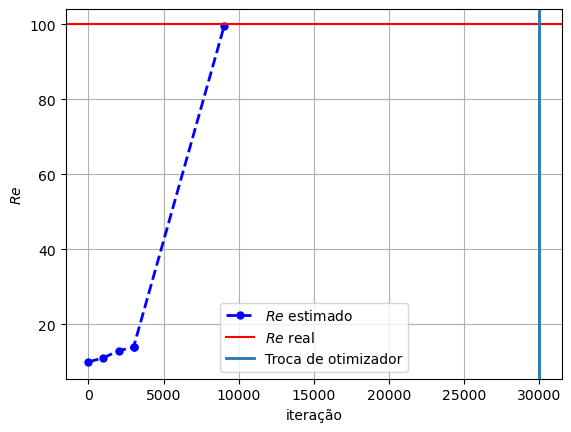

In [19]:
plot_parameter_approximation(f"./parameters/reynolds-{Re}.dat", Re, f"reynolds_nonoise-{Re}")

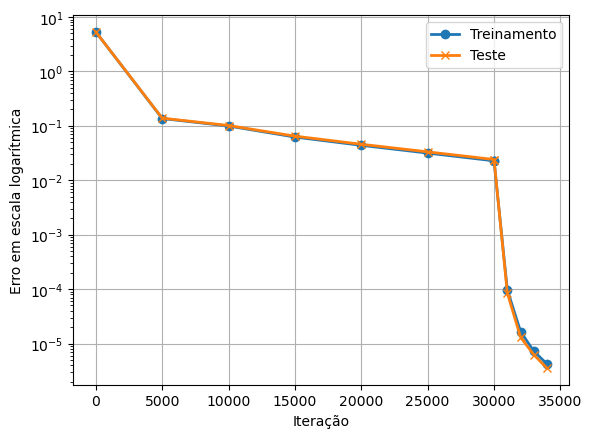

In [15]:
plot_and_save_losses(losshistory, f"reynolds_nonoise_loss-{Re}")

# Experimento com ruído
---
Vamos repetir o experimento acima, mas adicionando ruído gaussiano aos dados e às condições de fronteira.

In [20]:
noise_std_percentage = 0.2

In [21]:
def noisy_u_sol(x):
    noise_std = x.max() * noise_std_percentage
    u = u_sol(x)
    return u + np.random.normal(scale=noise_std, size=u.shape)

def noisy_v_sol(x):
    noise_std = x.max() * noise_std_percentage
    v = v_sol(x)
    return v + np.random.normal(scale=noise_std, size=v.shape)

def noisy_p_sol(x):
    noise_std = x.max() * noise_std_percentage
    p = p_sol(x)
    return p + np.random.normal(scale=noise_std, size=p.shape)

In [22]:
noisy_u_bc = dde.icbc.DirichletBC(
    spatial_domain, noisy_u_sol, lambda _, on_boundary: on_boundary, component=0
)

noisy_v_bc = dde.icbc.DirichletBC(
    spatial_domain, noisy_v_sol, lambda _, on_boundary: on_boundary, component=1
)

noisy_right_p_bc = dde.icbc.DirichletBC(
    spatial_domain, noisy_p_sol, boundary_outflow, component=2
)

noisy_data_u = noisy_u_sol(data_cp)
noisy_data_v = noisy_v_sol(data_cp)
noisy_data_p = noisy_p_sol(data_cp)

noisy_data_u_bc = dde.icbc.PointSetBC(data_cp, noisy_data_u, component=0)
noisy_data_v_bc = dde.icbc.PointSetBC(data_cp, noisy_data_v, component=1)
noisy_data_p_bc = dde.icbc.PointSetBC(data_cp, noisy_data_p, component=2)

In [23]:
noisy_data = dde.data.PDE(
    spatial_domain,
    pde,
    [
        noisy_u_bc, noisy_v_bc, noisy_right_p_bc,
        noisy_data_u_bc, noisy_data_v_bc, noisy_data_p_bc
    ],
    num_domain=num_domain,
    num_boundary=num_boundary,
    num_test=num_test,
    anchors=data_cp
)

In [24]:
noisy_model = dde.Model(noisy_data, net)

In [21]:
ex_Re = dde.Variable(Re_guess)

noisy_ex_variable_cb = dde.callbacks.VariableValue(
    [ex_Re], 
    period=1000, 
    filename=f"./parameters/noisy_reynolds-{Re}.dat"
)

noisy_model.compile("adam", lr=1e-3, external_trainable_variables=[ex_Re])

adam_iterations = 30000

noisy_losshistory, noisy_train_state = noisy_model.train(
    iterations=30000, 
    display_every=5000,
    callbacks=[noisy_ex_variable_cb])

noisy_model.compile("L-BFGS", external_trainable_variables=[ex_Re])
noisy_losshistory, noisy_train_state = noisy_model.train(
    display_every=5000, 
    callbacks=[noisy_ex_variable_cb])

Compiling model...
'compile' took 0.000183 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [5.74e+00, 2.07e-02, 7.78e-07, 3.93e-02, 3.85e-02, 3.81e-02, 3.82e-02, 4.18e-02, 3.93e-02]    [5.21e+00, 2.20e-02, 6.37e-07, 3.93e-02, 3.85e-02, 3.81e-02, 3.82e-02, 4.18e-02, 3.93e-02]    []  
5000      [2.51e-02, 2.47e-03, 4.05e-03, 6.68e-02, 4.20e-02, 4.00e-02, 1.24e-01, 4.56e-02, 5.74e-02]    [2.83e-02, 1.24e-03, 3.80e-03, 6.68e-02, 4.20e-02, 4.00e-02, 1.24e-01, 4.56e-02, 5.74e-02]    []  
10000     [2.12e-02, 2.28e-03, 3.56e-03, 5.54e-02, 3.99e-02, 4.00e-02, 9.12e-02, 4.41e-02, 5.29e-02]    [2.37e-02, 1.52e-03, 3.81e-03, 5.54e-02, 3.99e-02, 4.00e-02, 9.12e-02, 4.41e-02, 5.29e-02]    []  
15000     [2.98e-02, 2.19e-03, 3.49e-03, 4.85e-02, 3.94e-02, 3.96e-02, 7.21e-02, 4.40e-02, 4.95e-02]    [3.19e-02, 1

In [22]:
dde.saveplot(
    noisy_losshistory, 
    noisy_train_state, 
    issave=True, 
    isplot=False, 
    output_dir="./losses", 
    loss_fname=f"Re{Re}-noisy-loss",
    train_fname=f"Re{Re}-noisy-train",
    test_fname=f"Re{Re}-noisy-test")

noisy_model.save(f"./models/Re{Re}-noisy")

Saving loss history to ./losses/Re100-noisy-loss ...
Saving training data to ./losses/Re100-noisy-train ...
Saving test data to ./losses/Re100-noisy-test ...


'./models/Re100-noisy-32907.pdparams'

In [15]:
ex_Re.cpu().numpy()

array(99.60999, dtype=float32)

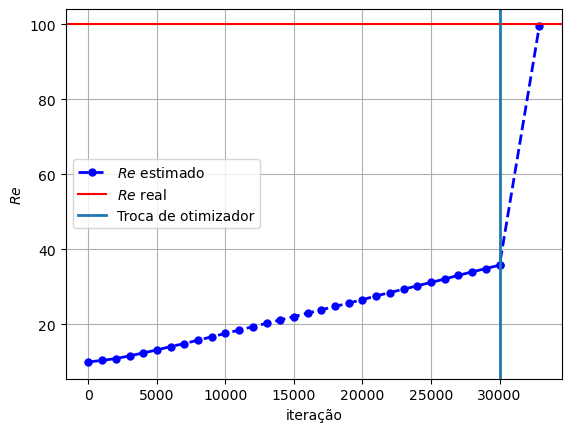

In [16]:
plot_parameter_approximation(f"./parameters/noisy_reynolds-{Re}.dat", Re, f"noisy_reynolds-{Re}")

In [17]:
plot_and_save_losses(noisy_losshistory, f"noisy_reynolds_loss-{Re}")

NameError: name 'noisy_losshistory' is not defined

## Comparando resultados

### Visualizando superfícies

In [30]:
noisy_model.restore(f"./models/Re1000-nonoise-60000.pdparams")

AssertionError: Variable dtype not match, Variable [ linear_0.w_0 ] need tensor with dtype paddle.float32  but load tensor with dtype paddle.float64

In [25]:
nop = 100

X = np.linspace(-0.5, 1, nop)
Y = np.linspace(-0.5, 1.5, nop)

X, Y = np.meshgrid(X, Y)
XY = np.vstack((X.flatten(), Y.flatten())).T

predicted_values = noisy_model.predict(XY)

u_predicted = predicted_values[:,0].reshape((nop, nop))
u_real = u_sol(XY).reshape((nop, nop))
u_noisy = noisy_u_sol(XY).reshape((nop, nop))

v_predicted = predicted_values[:,1].reshape((nop, nop))
v_real = v_sol(XY).reshape((nop, nop))
v_noisy = noisy_v_sol(XY).reshape((nop, nop))

p_predicted = predicted_values[:,2].reshape((nop, nop))
p_real = p_sol(XY).reshape((nop, nop))
p_noisy = noisy_p_sol(XY).reshape((nop, nop))

TypeError: 'NoneType' object is not callable

In [27]:
def plot_3d_projection(surface, title):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(Y, X, surface, vmin=surface.min() * 2, cmap="viridis")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.savefig(f"./images/{title}-{Re}.png")
    plt.show()

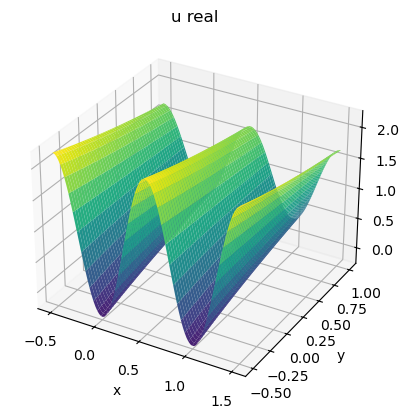

In [28]:
plot_3d_projection(u_real, r"$u$ real")

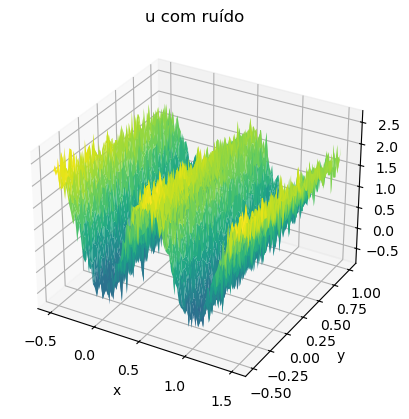

In [29]:
plot_3d_projection(u_noisy, r"$u$ com ruído")

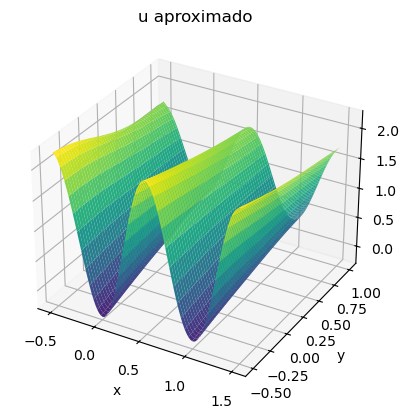

In [30]:
plot_3d_projection(u_predicted, r"$u$ aproximado")

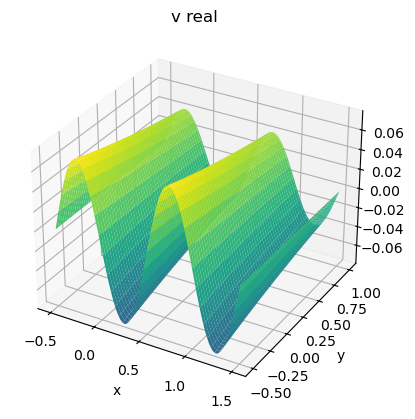

In [31]:
plot_3d_projection(v_real, r"$v$ real")

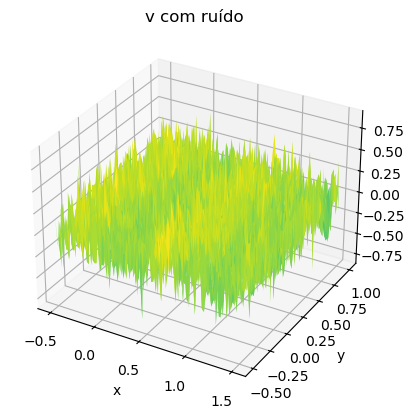

In [32]:
plot_3d_projection(v_noisy, r"$v$ com ruído")

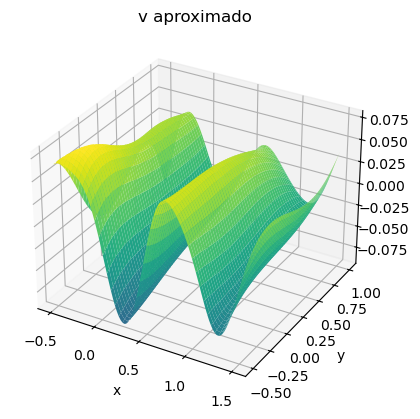

In [33]:
plot_3d_projection(v_predicted, r"$v$ aproximado")

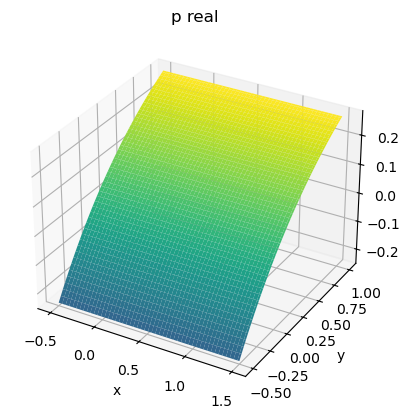

In [34]:
plot_3d_projection(p_real, r"$p$ real")

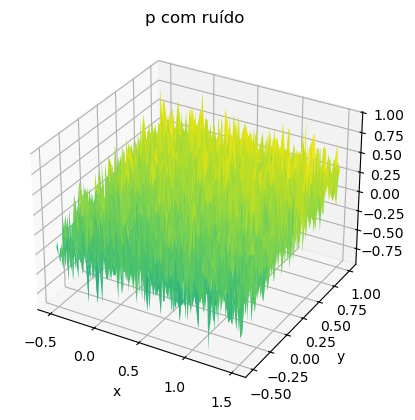

In [35]:
plot_3d_projection(p_noisy, r"$p$ com ruído")

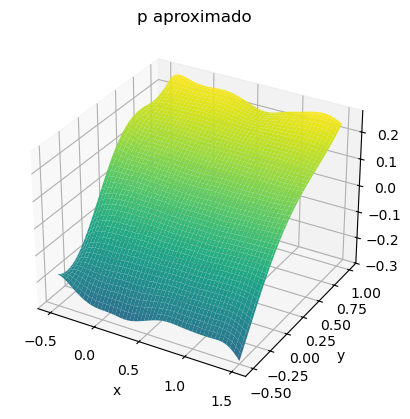

In [36]:
plot_3d_projection(p_predicted, r"$p$ aproximado")

### MSE

In [37]:
dde.metrics.mean_squared_error(u_real, u_predicted)

0.0005022854237124311

In [38]:
dde.metrics.mean_squared_error(v_real, v_predicted)

0.00014316260813638932

In [39]:
dde.metrics.mean_squared_error(p_real, p_predicted)

0.0004846524910818091

### MAPE

In [40]:
dde.metrics.mean_absolute_percentage_error(u_real, u_predicted)

np.float64(7.98957442351853)

In [41]:
dde.metrics.mean_absolute_percentage_error(v_real, v_predicted)

np.float64(388125.2328997595)

In [42]:
dde.metrics.mean_absolute_percentage_error(p_real, p_predicted)

np.float64(163326.3936373722)

### Acurácia

In [43]:
dde.metrics.accuracy(u_real, u_predicted)

np.float64(0.83)

In [44]:
dde.metrics.accuracy(v_real, v_predicted)

np.float64(0.56)

In [45]:
dde.metrics.accuracy(p_real, p_predicted)

np.float64(0.99)

### L2

In [46]:
dde.metrics.l2_relative_error(u_real, u_predicted)

np.float64(0.01855927628587162)

In [47]:
dde.metrics.l2_relative_error(v_real, v_predicted)

np.float64(0.2911617446217759)

In [48]:
dde.metrics.l2_relative_error(p_real, p_predicted)

np.float64(0.13630187537561955)

### L-Infinity

In [49]:
np.max(np.abs(u_real - u_predicted))

np.float64(0.06820370548217047)

In [50]:
np.max(np.abs(v_real - v_predicted))

np.float64(0.06590735912322997)

In [51]:
np.max(np.abs(p_real - p_predicted))

np.float64(0.0866708180771083)